In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras import optimizers

In [ ]:
df = pd.read_excel('Biak Numfor Clean.xlsx', index_col='Date')

In [ ]:
df.head()

,Tn,Tx,RH_avg,RR,ss,ff_x,ddd_x
Date,,,,,,,
2010-01-01,25.0,29.8,88,16.6,2.4,4,180
2010-01-02,24.0,30.8,88,16.6,4.8,4,180
2010-01-03,25.0,31.1,88,30.9,5.8,4,315
2010-01-04,24.0,31.6,87,5.0,4.8,5,315
2010-01-05,21.0,30.8,87,0.3,5.8,4,315


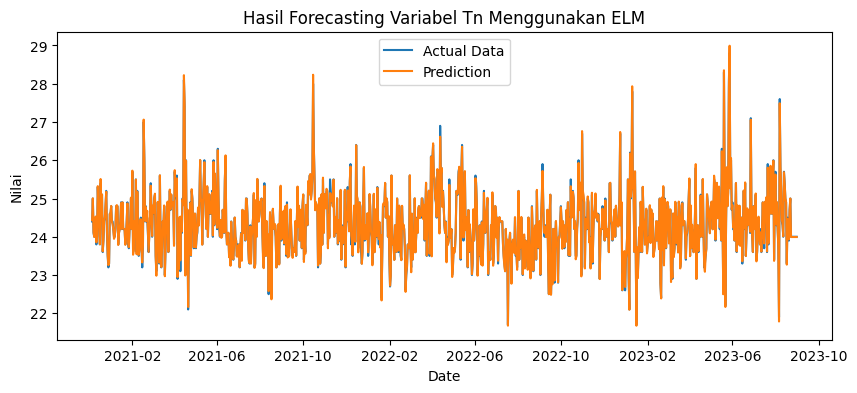

MAE: 0.031608568014682356
MAPE: 0.12972984199129142
MSE: 0.002660480696133532
RMSE: 0.05157984777152345
CV: 3.421368041495269


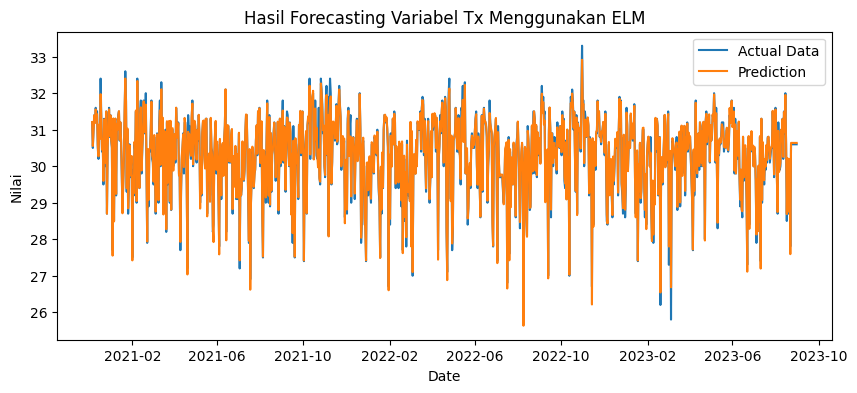

MAE: 0.0773983746418638
MAPE: 0.2573561934144269
MSE: 0.014126039511277869
RMSE: 0.11885301641640346
CV: 3.5446062604360464


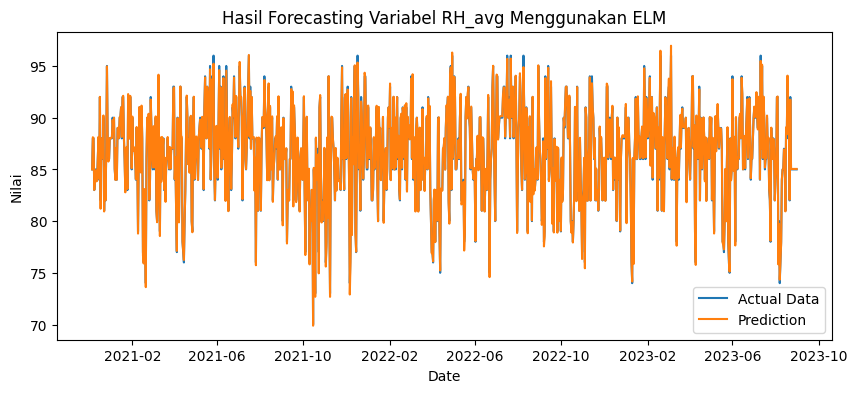

MAE: 0.13256253065396373
MAPE: 0.15371758338835784
MSE: 0.038887812075296596
RMSE: 0.19719992919698678
CV: 5.016836277796161


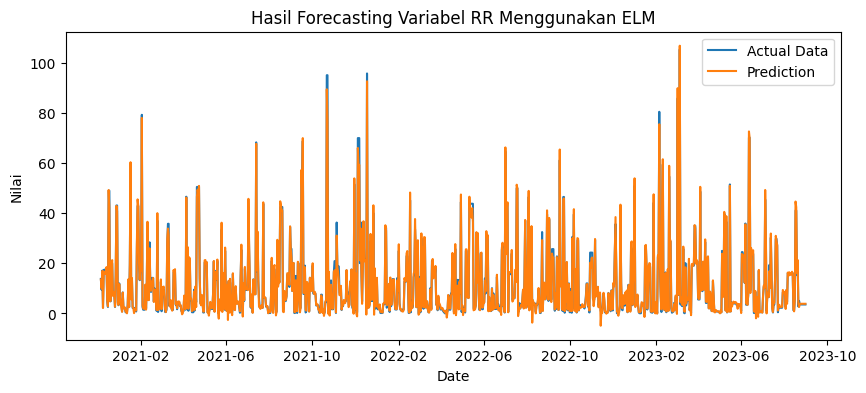

MAE: 0.8565500515503803
MAPE: 39.926590790324695
MSE: 2.151066112403693
RMSE: 1.4666513261180019
CV: 126.7864131352895


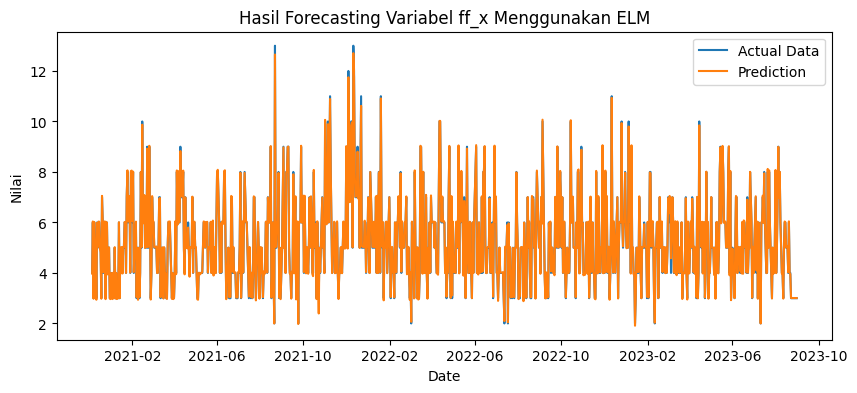

MAE: 0.03462308000440505
MAPE: 0.6914408108277486
MSE: 0.0031668552847307304
RMSE: 0.05627481927763723
CV: 32.03558480165719


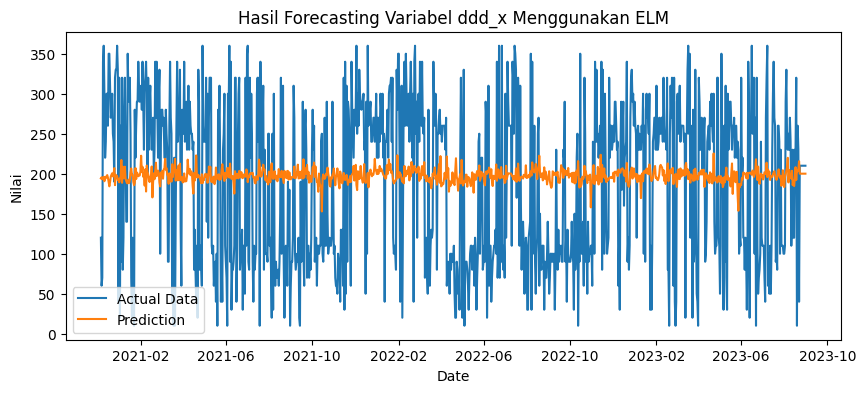

MAE: 90.8831147423841
MAPE: 118.27867177061664
MSE: 10041.764726828784
RMSE: 100.20860605171985
CV: 50.7590098466692


In [ ]:
# Melakukan forecasting menggunakan Extreme Learning Machine (ELM)
# Mengambil kolom yang akan digunakan untuk prediksi
selected_columns = ['Tn', 'Tx', 'RH_avg', 'RR', 'ff_x', 'ddd_x']
dataset = df[selected_columns]

#Preprocessing data
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(dataset)

#Membagi data menjadi trainingset dan testing set
train_size = int(len(scaled_dataset)* 0.8)
train_data = scaled_dataset[:train_size]
test_data = scaled_dataset[train_size:]

#Menghasilkan bobot secara acak
input_size = train_data.shape[1] - 1
hidden_size = 10 #Jumlah neuron pada hidden layer
output_size = 1 #Jumlah output
input_weights = np.random.normal(size=(input_size, hidden_size))
bias = np.random.normal(size=(hidden_size,))
output_weights = np.zeros((hidden_size, output_size))

#Membuat list untuk menyimpan prediksi dan data asli (testing) untuk setiap komoditas
pred_list = []
test_list = []

for i in range(len(selected_columns)):
  #Mengambil input (x) dan output (Y) dari data training dan testing
  train_X, train_Y = train_data[:, :-1], train_data[:, i]
  test_X, test_Y = test_data[:, :-1], test_data[:, i]

  #Menghitung output pada hidden layer
  hidden_output = 1/(1 + np.exp(-(np.dot(train_X, input_weights)+ bias)))

  #Menghitung bobot output
  output_weights = np.linalg.pinv(hidden_output).dot(train_Y)

  #Menghitung output prediksi pada data training
  train_pred = np.dot(hidden_output, output_weights)

  #Menghitung output prediksi pada data testing
  hidden_output_test = 1 / (1 + np.exp(-(np.dot(test_X, input_weights) + bias)))
  test_pred = np.dot(hidden_output_test, output_weights)

  #Mengembalikan data prediksi ke dalam skal aslinya
  test_pred = (test_pred * (scaler.data_max_[i] - scaler.data_min_[i])) + scaler.data_min_[i]

  # Mengembalikan data aktual ke dalam skala aslinya
  test_Y = (test_Y * (scaler.data_max_[i] - scaler.data_min_[i])) + scaler.data_min_[i]

  pred_list.append(test_pred)
  test_list.append(test_Y)

  # Mengatur indeks data sebagai sumbu x pada plot hasil prediksi
  times_test = dataset.index[train_size:]

  # Membuat dataframe untuk grafik
  grafik = pd.DataFrame({'Actual Data': test_Y.flatten(), 'Prediction': test_pred.flatten()}, index=times_test)

  # Plot hasil prediksi
  fig, ax = plt.subplots(figsize=(10, 4))
  ax.plot(times_test, test_Y, label="Actual Data")
  ax.plot(times_test, test_pred, label="Prediction")
  ax.set_xlabel('Date')
  ax.set_ylabel('Nilai')
  ax.set_title('Hasil Forecasting Variabel ' + selected_columns[i] + ' Menggunakan ELM')
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
  ax.legend()
  plt.show(fig)

  # Menghitung metrik evaluasi MAE, MAPE, MSE, RMSE, dan Coefficient of Variation (CV)
  from sklearn.metrics import mean_absolute_error, mean_squared_error

  # Menghitung MAE
  mae = mean_absolute_error(test_Y, test_pred)
  print('MAE:', mae)

  # Menghitung MAPE
  mape = np.mean(np.abs((test_Y - test_pred) / test_Y)) * 100
  print('MAPE:', mape)

  # Menghitung MSE
  mse = mean_squared_error(test_Y, test_pred)
  print('MSE:', mse)

  # Menghitung RMSE
  rmse = np.sqrt(mse)
  print('RMSE:', rmse)

  # Menghitung Coefficient of variation (CV)
  cv = np.std(test_Y) / np.mean(test_pred) * 100
  print('CV:', cv)

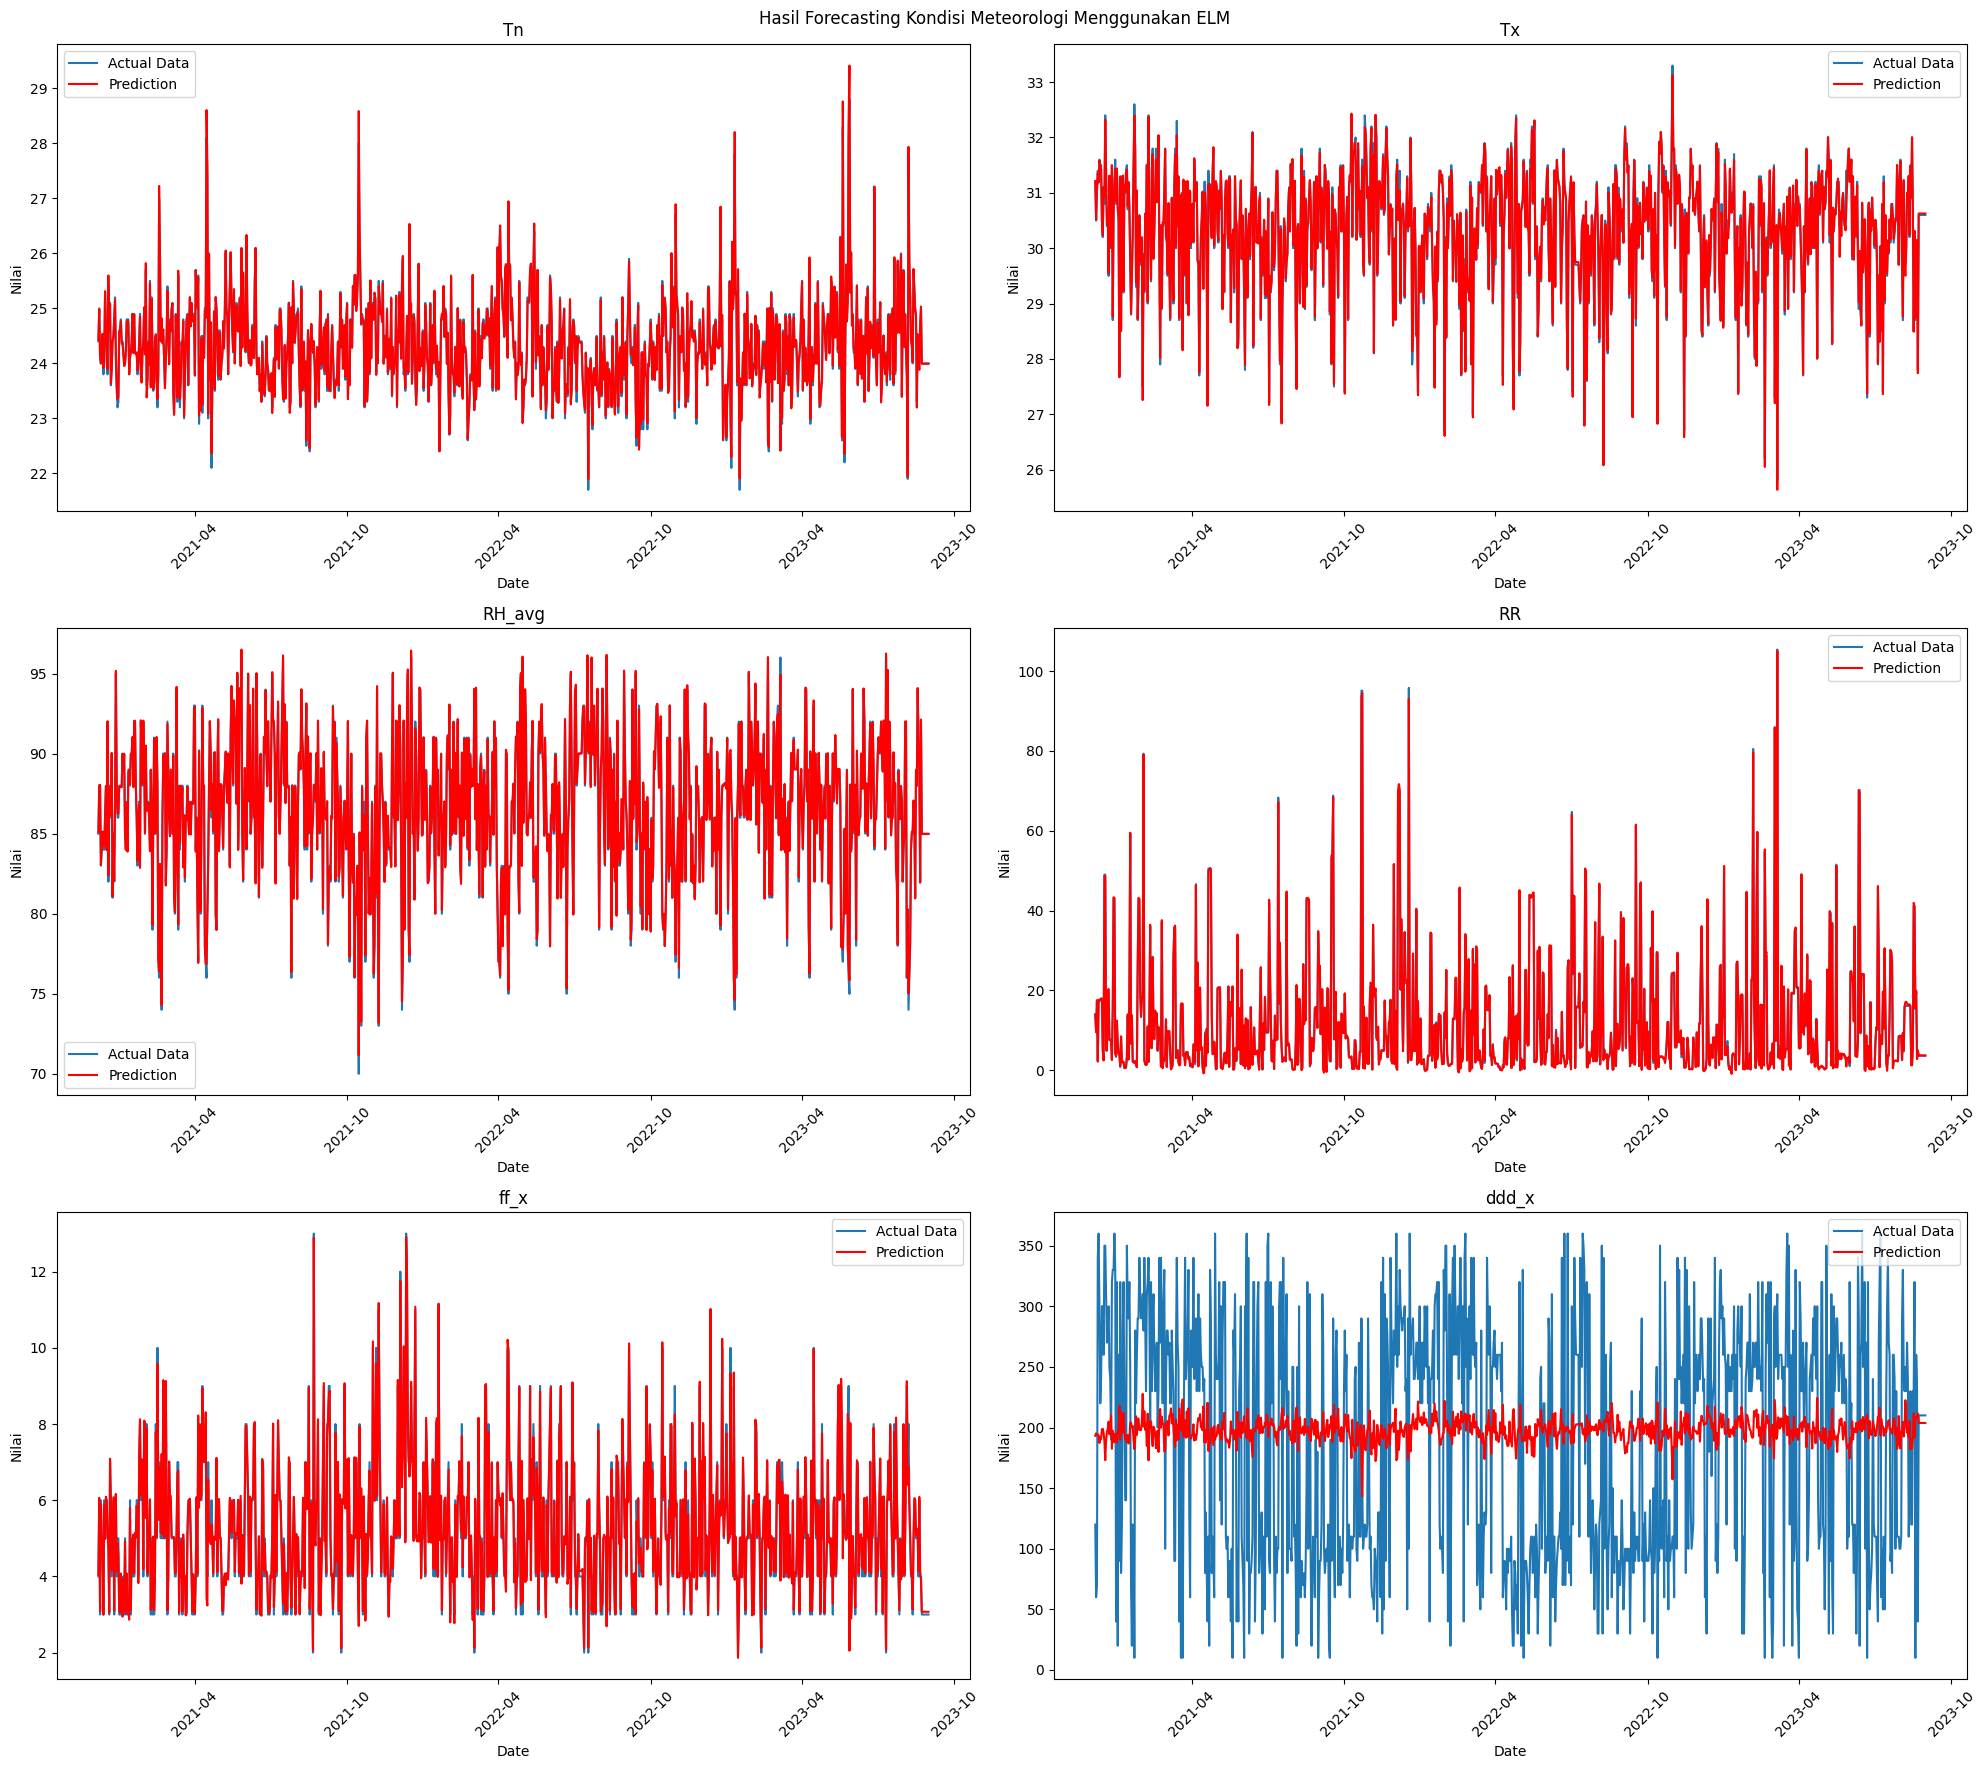

In [ ]:
# Mengatur jumlah baris dan kolom subplot
num_rows = 3 # Jumlah baris
num_cols = 2 # Jumlah kolom

# Membuat subplot dengan Layout yang ditentukan
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 18))

# Mengatur judul subplot
fig.suptitle('Hasil Forecasting Kondisi Meteorologi Menggunakan ELM')

# Menambahkan plot hasil prediksi ke setiap subplot
for i, ax in enumerate(axes.flat):
  if i < len(selected_columns):
    ax.plot(times_test, test_list[i], label='Actual Data')
    ax.plot(times_test, pred_list[i], label='Prediction', color='red')
    ax.set_title(selected_columns[i])
    ax.set_xlabel('Date')
    ax.set_ylabel('Nilai')
    ax.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6)) # Mengatur interval pada sumbu x menjadi 2 bulanan
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Mengatur format tanggal pada sumbu x
    ax.tick_params(axis='x', rotation=45) # Mengatur miring sumbu x sebesar 45 derajat

# Mengatur tampilan subplot agar tidak terlalu rapat
plt.tight_layout()

# Menampilkan gambar
plt.show()